In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, TensorDataset, DataLoader

import os
import numpy as np

from ImageClassifierNets import EarlyStopper, LightweightCNN
import matplotlib.pyplot as plt

In [70]:
model = LightweightCNN()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [71]:
# Check to see what device is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using the Apple MPS backend")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using the CUDA backend")
else:
    device = torch.device("cpu")
    print("Using the CPU backend")
    
model.to(device)
print(model)

# Input a dummy tensor to the model
dummy_input = torch.randn(1, 3, 120, 160, device=device)
out = model(dummy_input)
print(out.shape)
print(out)

Using the Apple MPS backend
LightweightCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=6, bias=True)
)
torch.Size([1, 6])
tensor([[-0.2534, -0.1539,  0.2136,  0.0590,  0.0476,  0.0093]],
       device='mps:0', grad_fn=<LinearBackward0>)


In [72]:
# Import training and validation dataset from npz file
train_val_path = '/Users/jvelasquez/Virginia_Tech/Spring_2023/ECE_4806/ieee-robotics-2023-code/src/jetson_code/pedestal_classification/pedestal_color_orientation_dataset.npz'
with np.load(train_val_path) as data:
    print(data.files)
    images = data['images']
    labels = data['labels']

# Preprocess the images
images = images.astype('float32') / 255
print(images[0].shape)

# Make labels shape (n, 1)
#labels.reshape(labels.shape[0], 1)

# Convert the numpy arrays to PyTorch tensors
images_tensor = torch.from_numpy(images)
labels_tensor = torch.from_numpy(labels)

# Load the testing set
test_path = '/Users/jvelasquez/Virginia_Tech/Spring_2023/ECE_4806/ieee-robotics-2023-code/src/jetson_code/pedestal_classification/pedestal_color_orientation_test_dataset_v2.npz'
with np.load(test_path) as data:
    print(data.files)
    test_images = data['images']
    test_labels = data['labels']

test_images = test_images.astype('float32') / 255
#test_labels = test_labels.reshape(test_labels.shape[0], 1)

# Shuffle test_images and test_labels together
p = np.random.permutation(len(test_images))
test_images = test_images[p]
test_labels = test_labels[p]

# Convert the numpy arrays to PyTorch tensors
test_images_tensor = torch.from_numpy(test_images)
test_labels_tensor = torch.from_numpy(test_labels)


['images', 'labels']
(3, 120, 160)
['images', 'labels']


In [73]:
# Define the dataset using the tensors
dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor)

# Take a portion of the the test images and labels and append them to the dataset
portion = int(len(test_images_tensor) * 0.75)
dataset = torch.utils.data.ConcatDataset([dataset, torch.utils.data.TensorDataset(test_images_tensor[:portion], test_labels_tensor[:portion])])

# Take the other portion of the test images and labels and use them as the test set
other_portion = int(len(test_images_tensor) - portion)
test_set = torch.utils.data.TensorDataset(test_images_tensor[other_portion:], test_labels_tensor[other_portion:])

# Define image transformations
# Define the image transformations
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(30),
#     transforms.ToTensor()
# ])

# Split the dataset into training, validation, and testing sets
train_split = 0.85
train_size = int(train_split * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# # Apply transformations to all images in the training set
# train_transformed = torch.utils.data.Subset(train_set, train_set.indices)
# train_transformed.dataset.transform = transform

# # Apply transformations to all images in the validation set     
# val_transformed = torch.utils.data.Subset(val_set, val_set.indices)
# val_transformed.dataset.transform = transform

# Create the dataloaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# test_set = torch.utils.data.TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [74]:
batch_size = 16
summary(model, input_size=(batch_size, 3, 120, 160), verbose=2, device=device)

Layer (type:depth-idx)                   Output Shape              Param #
LightweightCNN                           [16, 6]                   --
├─Conv2d: 1-1                            [16, 16, 60, 80]          448
│    └─weight                                                      ├─432
│    └─bias                                                        └─16
├─MaxPool2d: 1-2                         [16, 16, 29, 39]          --
├─Conv2d: 1-3                            [16, 32, 14, 19]          12,832
│    └─weight                                                      ├─12,800
│    └─bias                                                        └─32
├─MaxPool2d: 1-4                         [16, 32, 6, 8]            --
├─Conv2d: 1-5                            [16, 64, 2, 3]            51,264
│    └─weight                                                      ├─51,200
│    └─bias                                                        └─64
├─MaxPool2d: 1-6                         [16, 64, 1, 1]

Layer (type:depth-idx)                   Output Shape              Param #
LightweightCNN                           [16, 6]                   --
├─Conv2d: 1-1                            [16, 16, 60, 80]          448
│    └─weight                                                      ├─432
│    └─bias                                                        └─16
├─MaxPool2d: 1-2                         [16, 16, 29, 39]          --
├─Conv2d: 1-3                            [16, 32, 14, 19]          12,832
│    └─weight                                                      ├─12,800
│    └─bias                                                        └─32
├─MaxPool2d: 1-4                         [16, 32, 6, 8]            --
├─Conv2d: 1-5                            [16, 64, 2, 3]            51,264
│    └─weight                                                      ├─51,200
│    └─bias                                                        └─64
├─MaxPool2d: 1-6                         [16, 64, 1, 1]

In [75]:
num_epochs = 3000

# Create SummaryWriter for TensorBoard, create a new directory for each run by checking the number of directories in the model_logs directory
new_path = 'model_logs/no_transforms/run' + str(len(os.listdir('model_logs'))) + '/'

# Make the new directory
os.makedirs(new_path)

writer = SummaryWriter(log_dir=new_path)

# Write graph of the model to TensorBoard
writer.add_graph(model, dummy_input)

# Initialize lists to store loss and accuracy for each epoch
train_losses = []
train_accs = []
val_losses = []
val_accs = []
test_losses = []
test_accs = []

# Increment epoch counter
epochs = 0

# Define an early stopping object
early_stopper = EarlyStopper(patience=200, min_delta=0.0001)

for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader):

        # Send the data to mps
        images, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_acc = 100 * correct_train / total_train
    train_accs.append(train_acc)

    # Write to TensorBoard for logging
    # writer.add_scalar('Loss/train', train_loss, epoch)
    # writer.add_scalar('Accuracy/train', train_acc, epoch)
    
    # Validate
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            # Send the data to mps
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = 100 * correct_val / total_val
    val_accs.append(val_acc)

    # Write to TensorBoard for logging
    # writer.add_scalar('Loss/val', val_loss, epoch)
    # writer.add_scalar('Accuracy/val', val_acc, epoch)
    
    # Test
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            # Send the data to mps
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc = 100 * correct_test / total_test
    test_accs.append(test_acc)

    # Write to TensorBoard for logging
    # writer.add_scalar('Loss/test', test_loss, epoch)
    # writer.add_scalar('Accuracy/test', test_acc, epoch)

    writer.add_scalars(f'loss', {
    'train': train_loss,
    'val': val_loss,
    'test': test_loss,
}, epoch)
    
    writer.add_scalars(f'accuracy', {
    'train': train_acc,
    'val': val_acc,
    'test': test_acc,
}, epoch)
    
    # Print statistics
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'.format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc, test_loss, test_acc))
    
    # Increment epoch counter
    epochs += 1
    
    # Check if the model should stop early
    if early_stopper.early_stop(val_loss):             
        break


Epoch [1/3000], Train Loss: 1.7886, Train Acc: 17.70%, Val Loss: 1.7862, Val Acc: 16.41%, Test Loss: 1.7885, Test Acc: 17.96%
Epoch [2/3000], Train Loss: 1.7726, Train Acc: 18.97%, Val Loss: 1.7731, Val Acc: 16.41%, Test Loss: 1.7723, Test Acc: 17.96%
Epoch [3/3000], Train Loss: 1.7461, Train Acc: 18.59%, Val Loss: 1.7495, Val Acc: 15.18%, Test Loss: 1.7503, Test Acc: 22.43%
Epoch [4/3000], Train Loss: 1.6994, Train Acc: 21.92%, Val Loss: 1.6753, Val Acc: 18.56%, Test Loss: 1.7202, Test Acc: 26.30%
Epoch [5/3000], Train Loss: 1.5734, Train Acc: 32.76%, Val Loss: 1.4718, Val Acc: 41.56%, Test Loss: 1.6258, Test Acc: 33.90%
Epoch [6/3000], Train Loss: 1.3122, Train Acc: 44.93%, Val Loss: 1.0498, Val Acc: 49.54%, Test Loss: 1.2945, Test Acc: 51.71%
Epoch [7/3000], Train Loss: 0.9875, Train Acc: 50.87%, Val Loss: 0.7664, Val Acc: 75.61%, Test Loss: 0.9259, Test Acc: 51.27%
Epoch [8/3000], Train Loss: 0.8250, Train Acc: 56.45%, Val Loss: 0.6938, Val Acc: 62.27%, Test Loss: 0.8175, Test Acc:

In [76]:
# # Define the class names
# classes = ['Green_Side', 'Green_Up', 'Red_Side', 'Red_Up', 'White_Side', 'White_Up']

# # 1. gets the probability predictions in a test_size x num_classes Tensor
# # 2. gets the preds in a test_size Tensor
# # takes ~10 seconds to run
# class_probs = []
# class_label = []
# model.eval()
# with torch.no_grad():
#     for data in test_loader:
#         # Send the data to mps
#         images, labels = data[0].to(device), data[1].to(device)
#         output = model(images)
#         class_probs_batch = [F.softmax(el, dim=0) for el in output]

#         class_probs.append(class_probs_batch)
#         class_label.append(labels)

# test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
# test_label = torch.cat(class_label)

# # helper function
# def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
#     '''
#     Takes in a "class_index" from 0 to 5 and plots the corresponding
#     precision-recall curve
#     '''
#     tensorboard_truth = test_label == class_index
#     tensorboard_probs = test_probs[:, class_index]

#     writer.add_pr_curve(classes[class_index],
#                         tensorboard_truth,
#                         tensorboard_probs,
#                         global_step=global_step)

# # plot all the pr curves
# for i in range(len(classes)):
#     add_pr_curve_tensorboard(i, test_probs, test_label)



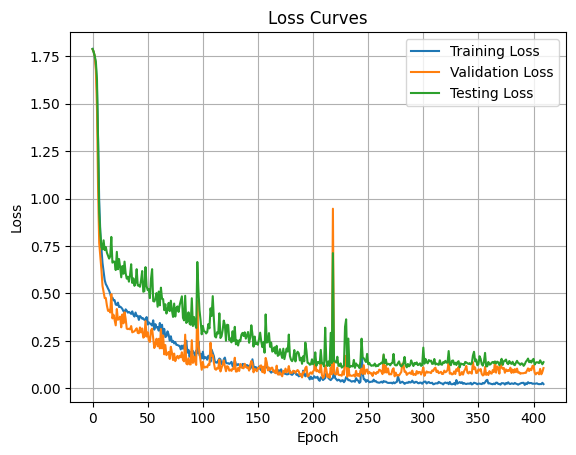

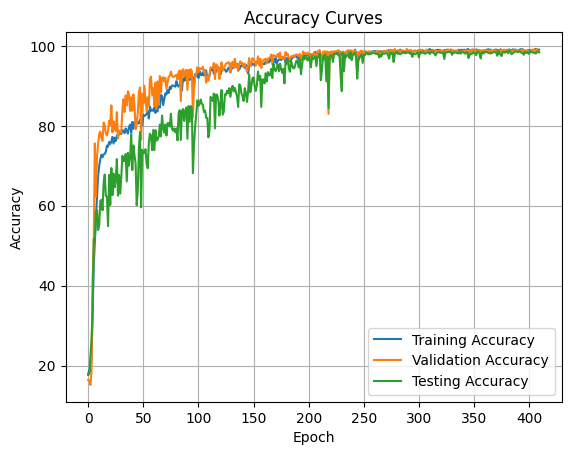

In [77]:
# Plot loss and accuracy curves for training, validation, and testing sets
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.plot(range(epochs), test_losses, label='Testing Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.plot(range(epochs), train_accs, label='Training Accuracy')
plt.plot(range(epochs), val_accs, label='Validation Accuracy')
plt.plot(range(epochs), test_accs, label='Testing Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


In [78]:
# Close the writer
writer.close()

# Save the model
torch.save(model.state_dict(), 'lightweight_net_color_orientation_v4.pth')